Para realizar la optimización debemos tener instaladas las librerías que aparecen abajo
en el siguiente segmento de código. Si tienes python instalado con la distribución de anaconda
entonces solo tendrás que installar la librería "Pandas DataReader", para esto puedes ir a la 
terminal y escribir: pip install pandas_datareader.

Una vez tengas las librerias instaladas las importamos como se muestra acontinuación.

In [1]:
import pandas as pd #to manipulaze databframes
import numpy as np # to generate random weigths and linear algebra 
from pandas_datareader import DataReader as wb # to get stocks data from yahoo finance
from scipy.optimize import minimize # to optimize sharpe-ratio
import matplotlib.pyplot as plt # to plot our data
import seaborn as sns # style of our plots

El primer paso es obtener la información desde Yahoo Finance, podríamos descargar uno a uno los datos
de las acciones, luego en excel sincronizar las fechas y cargar el archivo modificado de nuevo a
python. Sin embargo, el proceso de obtener y sincronizar los precios de las acciones se puede hacer
de una forma mucho más facil utilizando la librería "Pandas DataReader", específicamente
la función "DataReader" que cargamos inicialmente commo "wb". Con esto obtendremos los precios de
cada acción en un solo data frame utilizando unas pocas líneas de código.

Para cargar los precios desde Yahoo creamos una variable de tipo lista con los tickers de las acciones de Apple, Facebook, Amazon
y Microsoft, además, creamos dos variables llamadas "start" y "end" donde colocamos las fechas de inicio y
termino respectivamente como strings siguiendo el formato año-mes-día.

Una vez establecidos los inputs necesarios, creamos una variable llamada "df", la igualmos a la  función DataReader
abrebiada como "wb" y le pasamos los imputs. Primero se ponen los tickers, luego escribimos 'yahoo' (en minúscula)
y por pultimo las fechas de inicio y termino, es importante hacerlo en este orden. Una vez cerramos la función le 
agregamos el atributo ['Adj Close'], esto le dice a la función que de toda la información que tiene Yahoo sobre
las acciones, nos retorne solo los precios de cierre ajustados por dividendos, si quisieramos los precios sin ajuste
debemos escrbir el atributo ['Close'].

Esta funcicón nos devuelve un pandas data frame donde las columnas son los tickers de cada acción y el indice son las
fechas de cada día, dentro del data frame tenemos los precios diarios de cada acción.

In [2]:
# Define our stocks in the portfolio
tickers = ['BAC','TSLA']
# Get stock prices in Yahoo Finance
start = '2019-1-1'
end = '2021-1-1'
df = wb(tickers,'yahoo', start, end)['Adj Close']

Si utilizamos la función "print()" y le pasamos el data frame, podremos ver en la consola los datos que obtuvimos de Yahoo

In [3]:
print(df)

Symbols           BAC        TSLA
Date                             
2019-01-02  23.430696   62.023998
2019-01-03  23.055204   60.071999
2019-01-04  24.012709   63.537998
2019-01-07  23.993933   66.991997
2019-01-08  23.946999   67.070000
...               ...         ...
2020-12-24  29.535604  661.770020
2020-12-28  29.703196  663.690002
2020-12-29  29.584896  665.989990
2020-12-30  29.555321  694.780029
2020-12-31  29.880646  705.669983

[505 rows x 2 columns]


Posteriormenta hay que obetener los retornos diarios de cada acción, en este ejercicio calcularemos
retornos continuos los cuales son el logarítmon natural de la división entre el precio de cada día sobre el precio del
día anterior. Para esto utilizamos la función de numpy "log" que nos permite obtener el logaritmo natural de
lo que coloquemos dentro de esta, en este caso le pasamos el data frame (df) dividido por si mismo pero con la
función "shift(1)" de pandas, con esto estamos dividiendo cada fila del data frame con la fila anterior.

In [4]:
# Calculate continuous returns
df = np.log(df/df.shift(1))

Hacemos un print para ver cómo cambiaron los datos

In [5]:
print(df)

Symbols          BAC      TSLA
Date                          
2019-01-02       NaN       NaN
2019-01-03 -0.016155 -0.031978
2019-01-04  0.040692  0.056094
2019-01-07 -0.000782  0.052935
2019-01-08 -0.001958  0.001164
...              ...       ...
2020-12-24 -0.002999  0.024150
2020-12-28  0.005658  0.002897
2020-12-29 -0.003991  0.003459
2020-12-30 -0.001000  0.042321
2020-12-31  0.010947  0.015552

[505 rows x 2 columns]


Se puede apreciar como ahora en el data frame dejamos de tener precios y ahora tenemos números decimales
entre -1 y 1. Admemás, en la primera fila nos aparecen datos del tipo NaN, esto es porque anteriormente
calculamos el logaritmo natural de cada precio con el precio del día anterior, obviamente la primera fila
de precios no tenía precios anteriores con los que compararse por lo el resultado para la primera fila nos
arroja datos tipo NaN.

Para eliminar esta fila utilizamos la función de pandas "dropna()", la cual nos permite borrar del data frame
las filas que contengan datos del tipo NaN. Además, agregamos inmediatamente un print para ver el data frame

In [6]:
df = df.dropna()
print(df)

Symbols          BAC      TSLA
Date                          
2019-01-03 -0.016155 -0.031978
2019-01-04  0.040692  0.056094
2019-01-07 -0.000782  0.052935
2019-01-08 -0.001958  0.001164
2019-01-09  0.009752  0.009438
...              ...       ...
2020-12-24 -0.002999  0.024150
2020-12-28  0.005658  0.002897
2020-12-29 -0.003991  0.003459
2020-12-30 -0.001000  0.042321
2020-12-31  0.010947  0.015552

[504 rows x 2 columns]


In [13]:
simulations = 1000000
size = len(tickers)
weights = np.zeros((simulations,size))

In [14]:
for i in range(simulations):
   w = np.random.rand(size)
   weights[i] = w/w.sum()
print(weights)

[[0.42327819 0.57672181]
 [0.51564328 0.48435672]
 [0.80822599 0.19177401]
 ...
 [0.54471657 0.45528343]
 [0.30217577 0.69782423]
 [0.56897911 0.43102089]]


In [15]:
# Monte-Carlo simulation
ret = df.mean().values*252
cov = df.cov().values*252
mtx = np.zeros((simulations,3))
rf = 0.025
for i in range(simulations):
    mtx[i][0] = np.dot(weights[i],ret)
    mtx[i][1] = np.sqrt(np.dot(weights[i],np.dot(cov,weights[i].T)))
    mtx[i][2] = (mtx[i,0]-rf)/mtx[i,1]
mtx

array([[0.75264897, 0.50853049, 1.43088564],
       [0.65158021, 0.47486783, 1.31948339],
       [0.3314271 , 0.42369489, 0.72322585],
       ...,
       [0.61976731, 0.46575237, 1.2770033 ],
       [0.88516301, 0.56171267, 1.53132207],
       [0.59321848, 0.45874433, 1.23863871]])

In [16]:
portfolios = pd.DataFrame(
    columns=tickers + ['Ret','Std','Sharpe'],
    data = np.zeros((simulations,size+3))
)
for i in range(simulations):
    portfolios.iloc[i,:size] = weights[i]
    portfolios.iloc[i,size:] = mtx[i]
print(portfolios)

             BAC      TSLA       Ret       Std    Sharpe
0       0.423278  0.576722  0.752649  0.508530  1.430886
1       0.515643  0.484357  0.651580  0.474868  1.319483
2       0.808226  0.191774  0.331427  0.423695  0.723226
3       0.553858  0.446142  0.609764  0.463046  1.262863
4       0.611714  0.388286  0.546457  0.447807  1.164466
...          ...       ...       ...       ...       ...
999995  0.272733  0.727267  0.917380  0.575913  1.549504
999996  0.427794  0.572206  0.747708  0.506732  1.426212
999997  0.544717  0.455283  0.619767  0.465752  1.277003
999998  0.302176  0.697824  0.885163  0.561713  1.531322
999999  0.568979  0.431021  0.593218  0.458744  1.238639

[1000000 rows x 5 columns]


In [17]:
max_sharpe = portfolios['Sharpe'].max()
optimal_portfolio = portfolios[portfolios['Sharpe'] == max_sharpe]
print(optimal_portfolio)

             BAC      TSLA       Ret       Std    Sharpe
776971  0.000005  0.999995  1.215807  0.724158  1.644404


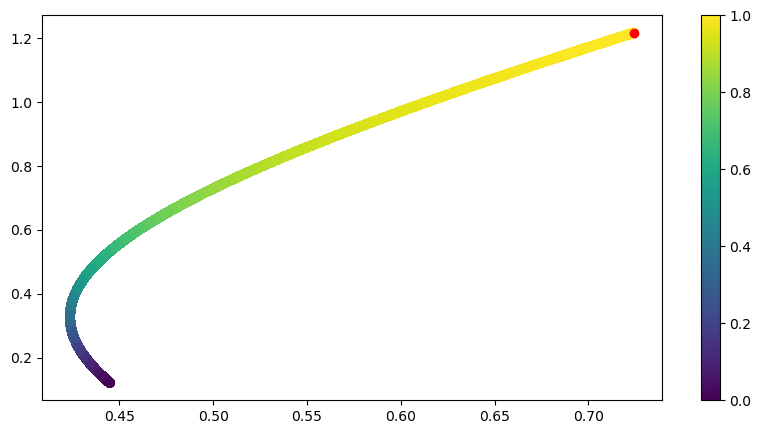

In [18]:
x1 = portfolios['Std'].values
y1 = portfolios['Ret'].values
x2 = optimal_portfolio['Std'].values
y2 = optimal_portfolio['Ret'].values

plt.figure(figsize=(10,5))
plt.scatter(x1,y1,c=y1/x1)
plt.scatter(x2,y2,color = 'red')
plt.colorbar()
plt.show()